C:\Users\pmaciejonczyk\AppData\Local\Temp\ipykernel_6828\3117408379.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


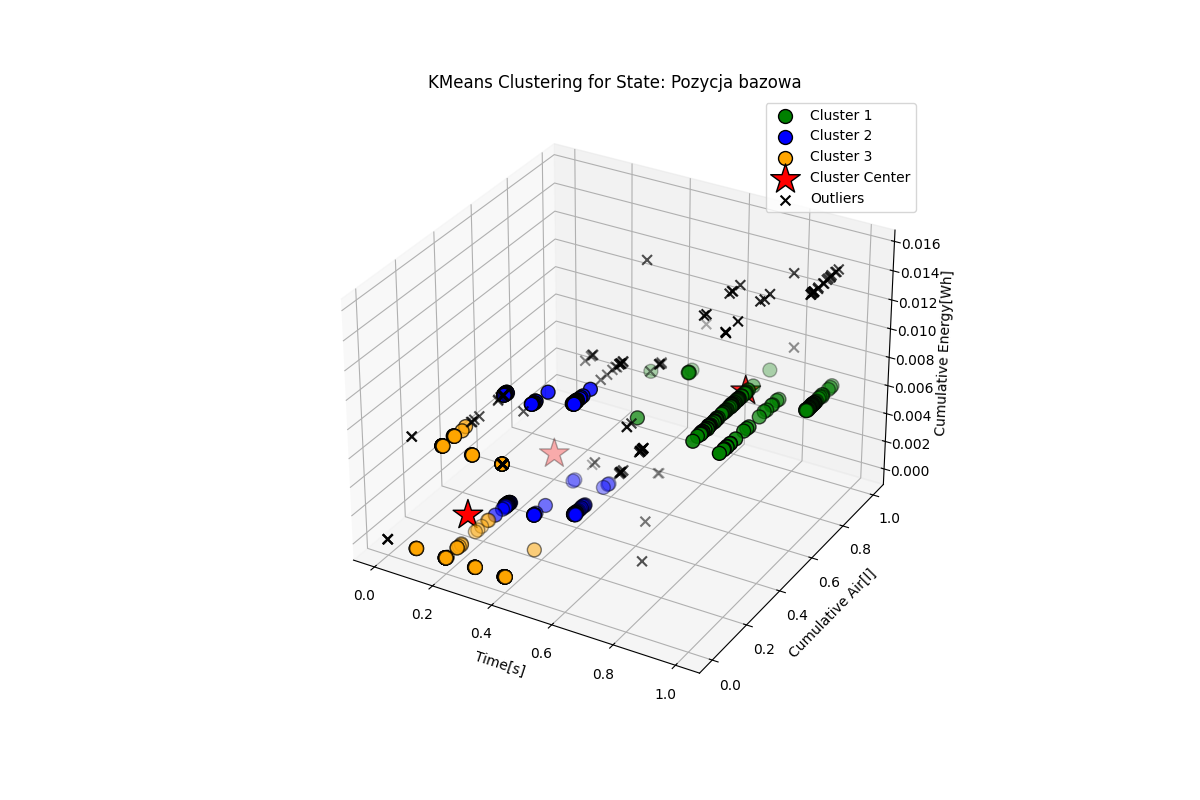

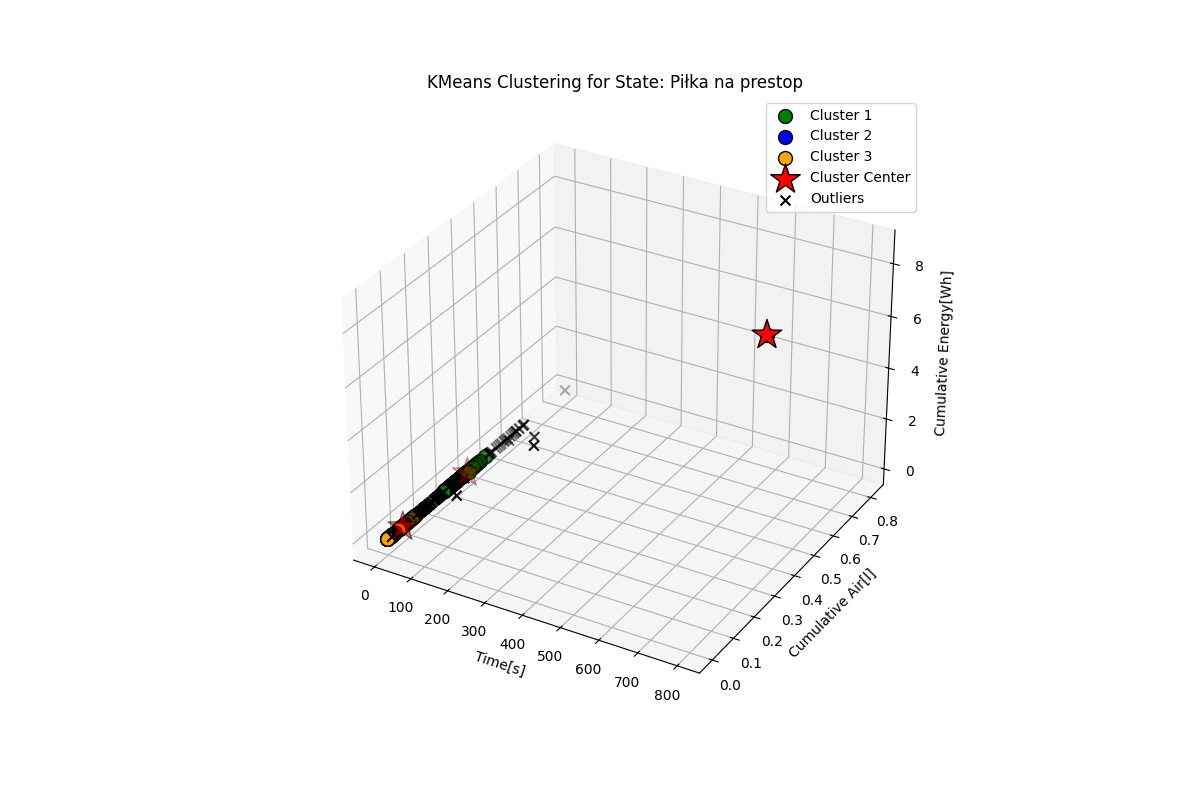

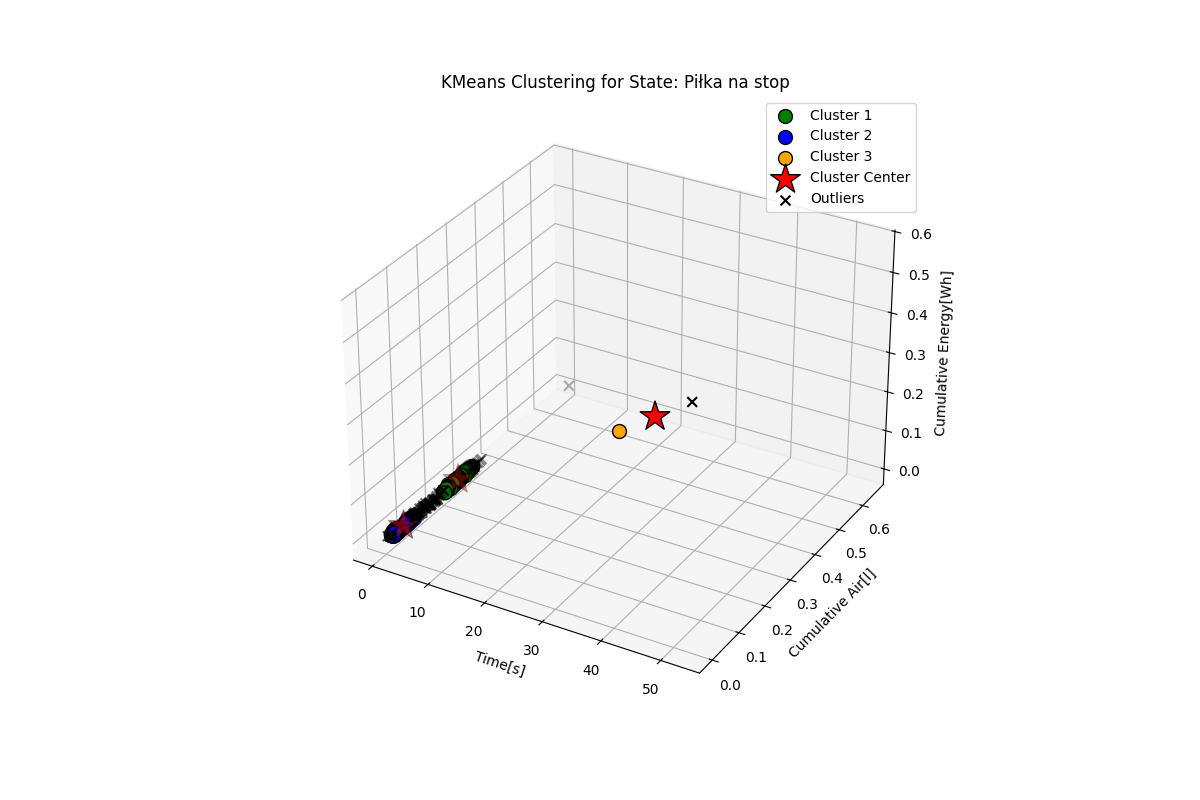

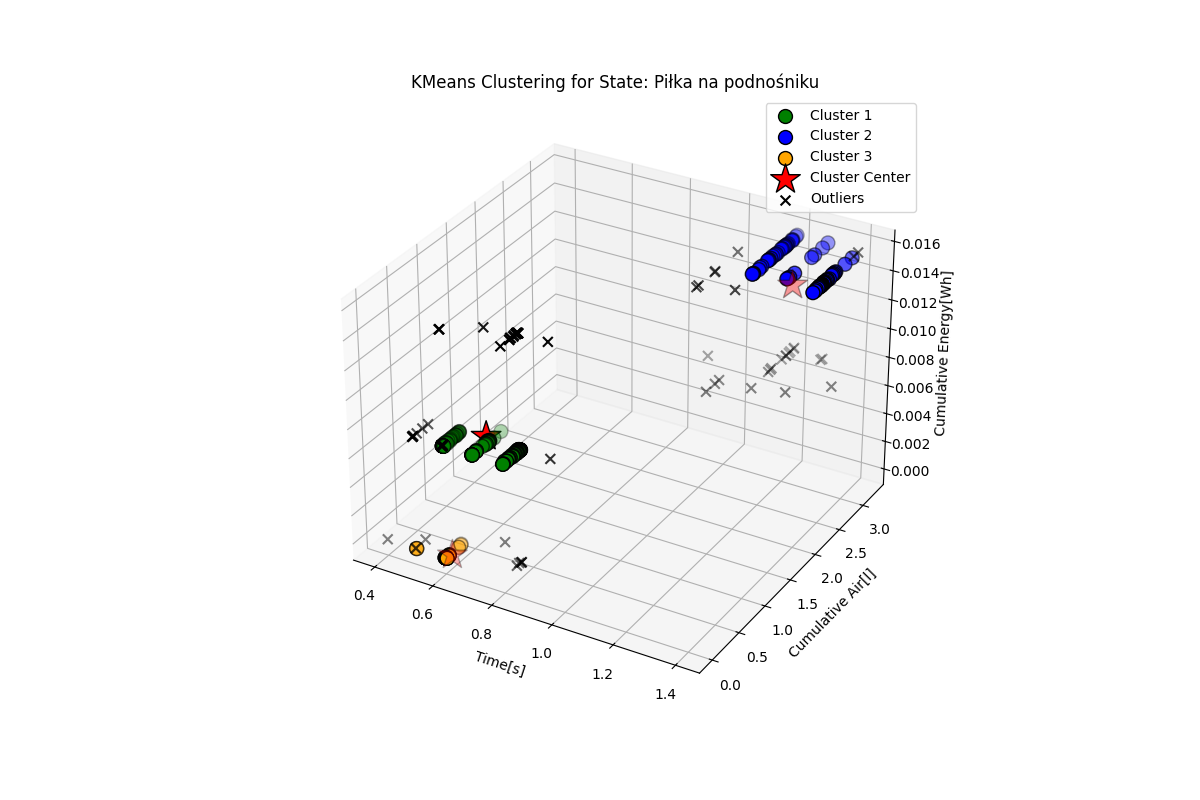

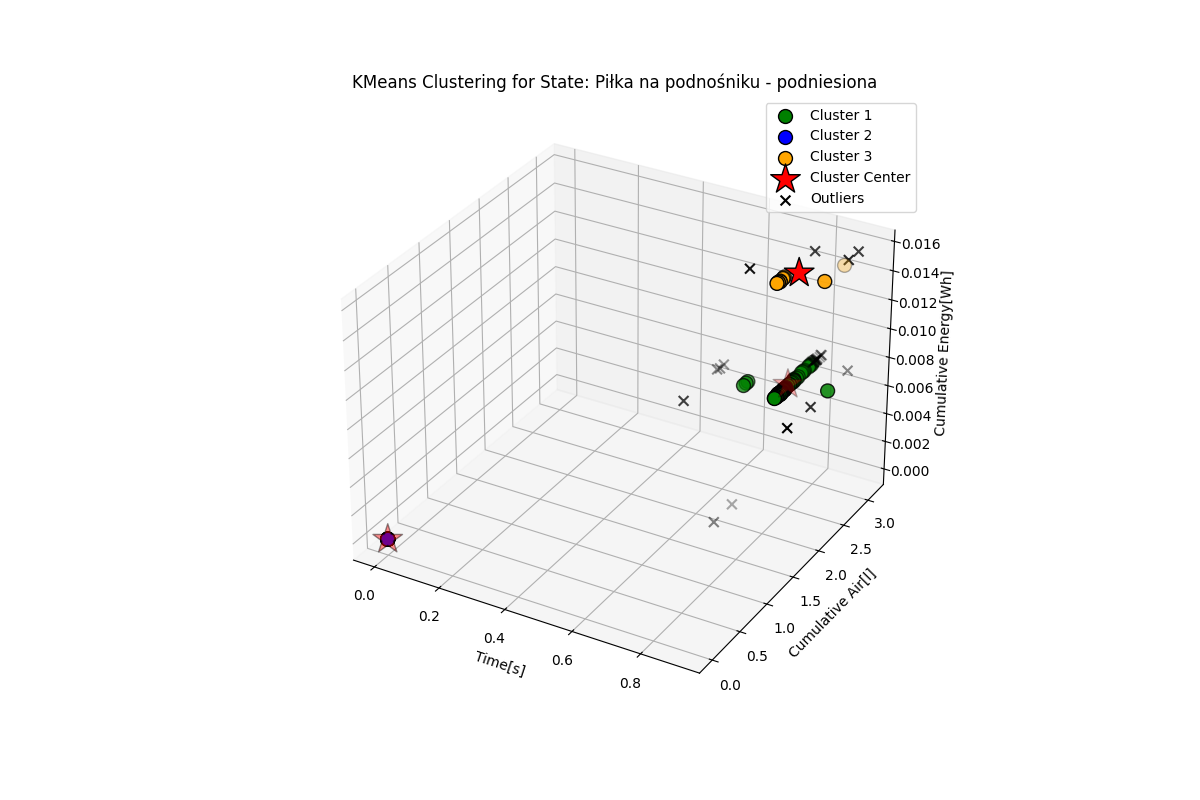

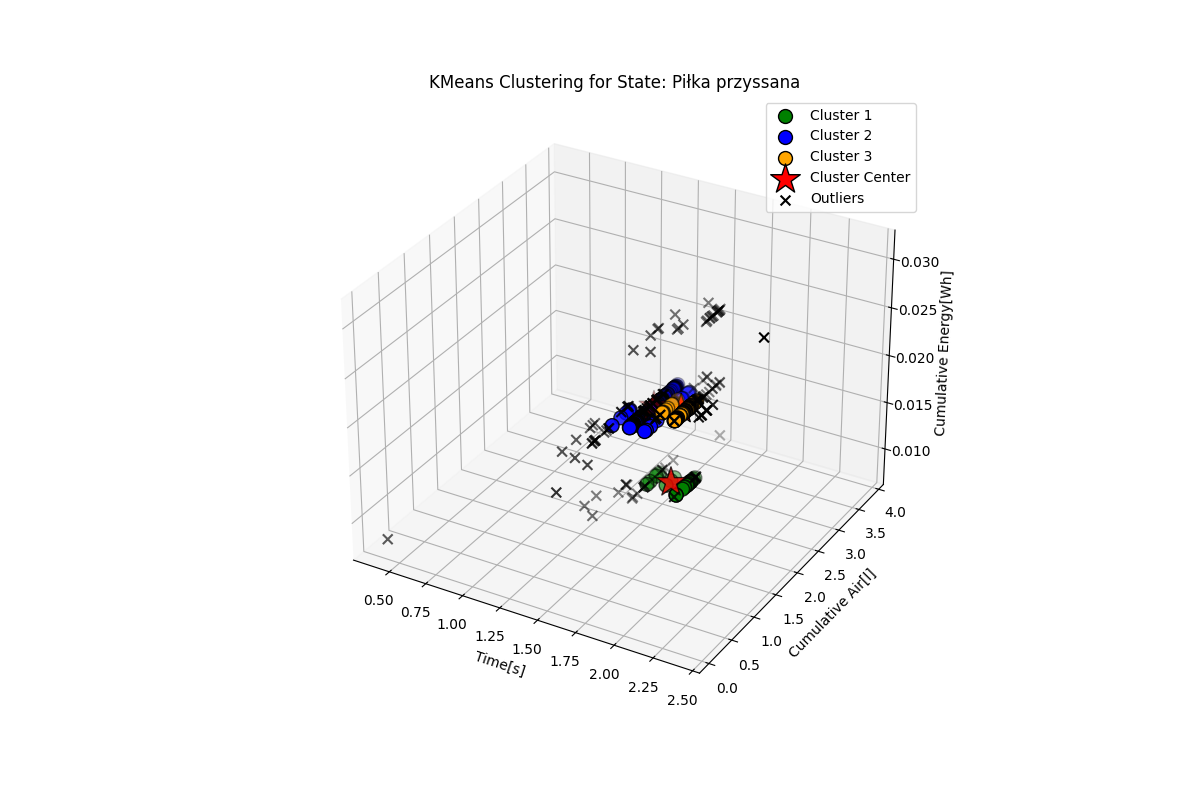

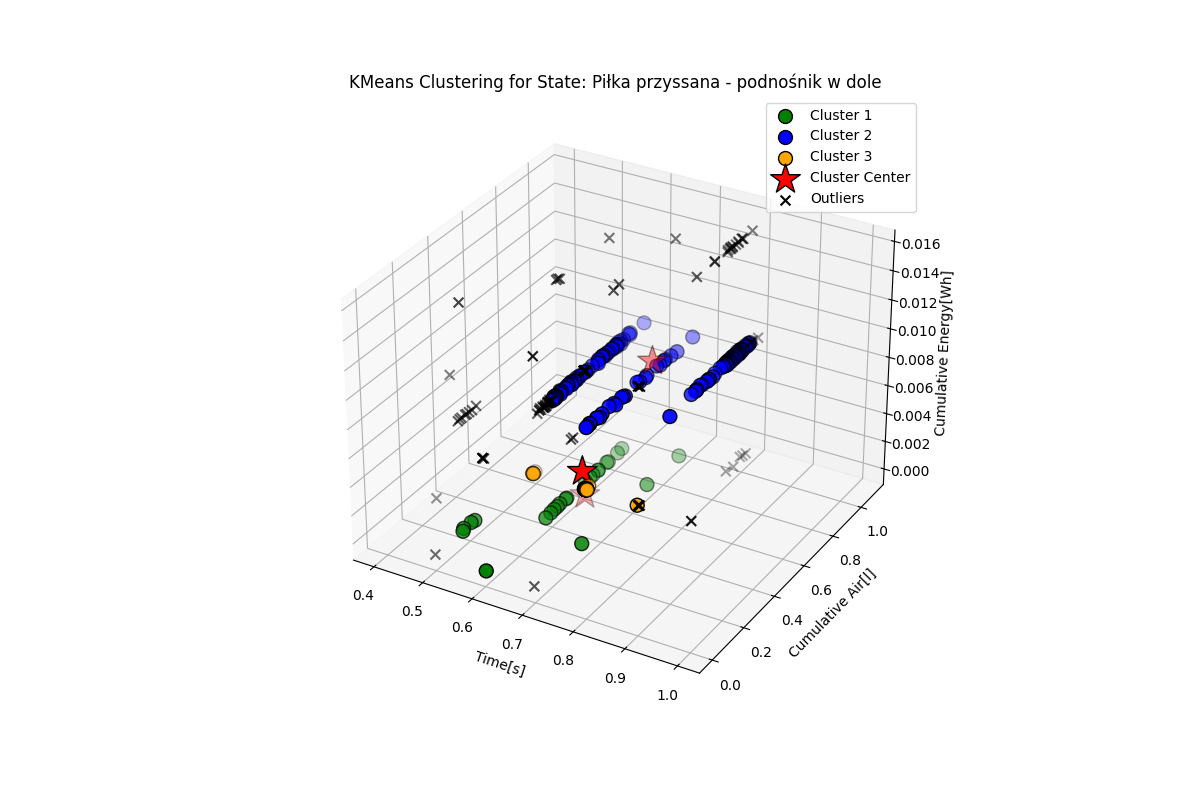

C:\Users\pmaciejonczyk\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


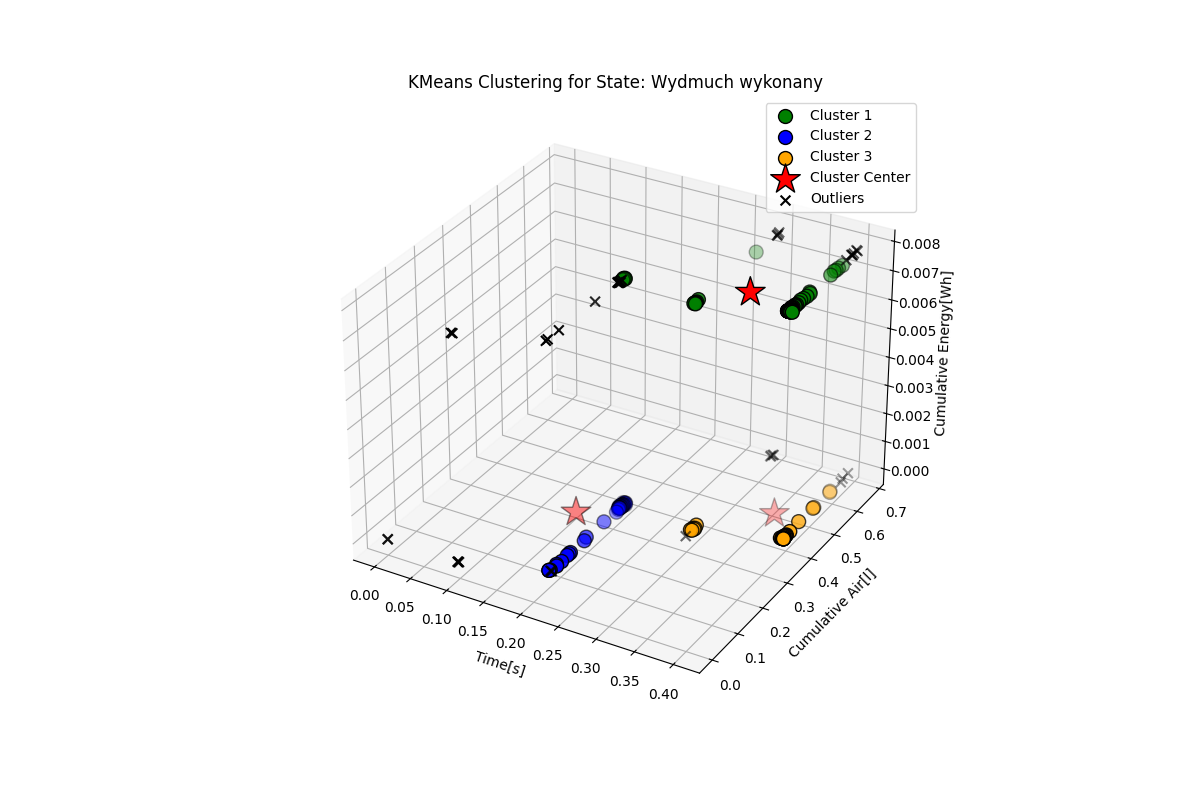

In [10]:
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import mysql.connector
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import sys
import seaborn as sns


def retrieve_data(mode=0):
    conn = mysql.connector.connect(
        host=os.getenv('MY_SQL_HOST'),
        user=os.getenv('MY_SQL_USER'),
        password=os.getenv('MY_SQL_PASS'),
        database=os.getenv('MY_SQL_DB')
    )

    df = None
    match mode:
        case 0:
            query = "SELECT * FROM states_measurements"
            df = pd.read_sql(query, conn)
        case 1:
            query = "SELECT * FROM cycles_measurements"
            df = pd.read_sql(query, conn)

    conn.close()
    return df


def plot_states_data(data):
    states_strings = ["Pozycja bazowa", "Piłka na prestop", "Piłka na stop", "Piłka na podnośniku",
                      "Piłka na podnośniku - ssawka wysunięta", "Piłka na podnośniku - podniesiona",
                      "Piłka przyssana", "Piłka przyssana - podnośnik w dole",
                      "Piłka przyssana - ssawka wsunięta", "Wydmuch wykonany"]

    states = [2 ** num for num in range(len(states_strings) + 1)]

    counter = 0
    %matplotlib widget
    for state in states:
        # Filter data for the current state
        state_data = data[data['state'] == state].copy()

        if state_data.shape[0] == 0:
            counter += 1
            continue

        # Define the features
        features = ['time', 'cumulative_air', 'cumulative_energy']
        X = state_data[features].values

        scaler = StandardScaler()
        X = scaler.fit_transform(X)

        # Apply KMeans clustering
        kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

        # Get the cluster center
        centers_scaled = kmeans.cluster_centers_

        centers = scaler.inverse_transform(centers_scaled)

        # Calculate the distance of each point from the cluster centers
        labels = kmeans.labels_
        distances = np.linalg.norm(X - centers_scaled[labels], axis=1)

        # Define thresholds for outliers (e.g., the 75th percentile)
        thresholds = []
        for i in range(3):
            # Get distances for the current cluster
            cluster_distances = distances[labels == i]

            if len(cluster_distances) > 0:
                # Calculate the 75th percentile for non-empty clusters
                thresholds.append(np.percentile(cluster_distances, 75))
            else:
                # If a cluster is empty, append a large number to avoid marking points as outliers
                thresholds.append(np.inf)

        # Mark outliers
        state_data['distance_from_center'] = distances
        state_data['is_outlier'] = np.array([distances[i] > thresholds[labels[i]] for i in range(len(distances))])
        state_data['cluster'] = labels

        # Plot the results
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        colors = ['green', 'blue', 'orange']

        for i in range(3):
            # Plot in-cluster points
            in_cluster = state_data[(state_data['cluster'] == i) & (~state_data['is_outlier'])]
            ax.scatter(in_cluster['time'], in_cluster['cumulative_air'], in_cluster['cumulative_energy'],
                       s=100, c=colors[i], edgecolors='black', label=f'Cluster {i+1}')

        ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2],
                   s=500, c='red', edgecolors='black', marker='*', label=f'Cluster Center')

        outliers = state_data[state_data['is_outlier']]
        if len(outliers) > 0:
            ax.scatter(outliers['time'], outliers['cumulative_air'], outliers['cumulative_energy'],
                    s=50, c='black', marker='x', label='Outliers')

        ax.set_title(f'KMeans Clustering for State: {states_strings[counter]}')
        ax.set_xlabel('Time[s]')
        ax.set_ylabel('Cumulative Air[l]')
        ax.set_zlabel('Cumulative Energy[Wh]')
        ax.legend()

        plt.show()

        plt.savefig(f'charts/states/{states_strings[counter]}.png')
        # plt.close()
        counter += 1


def plot_cycles_data(data):
    features = ['time', 'cumulative_air', 'cumulative_energy']
    X = data[features].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    dbscan = DBSCAN(eps=0.2, min_samples=5).fit(X_scaled)
    labels = dbscan.labels_

    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    palette = sns.color_palette("husl", n_clusters)

    # Plot the results
    %matplotlib widget
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    for label, color in zip(unique_labels, palette):
        # Mask points belonging to the current cluster
        mask = (labels == label)
        if label == -1:
            # Black used for noise (outliers)
            ax.scatter(X[mask, 0], X[mask, 1], X[mask, 2], c='black', label=f'Cluster {label}',
                       s=50, marker="x")
        else:
            ax.scatter(X[mask, 0], X[mask, 1], X[mask, 2], c=[color], label=f'Cluster {label}',
                    edgecolors='black', s=100)

    ax.set_title(f'DBSCAN Clustering for three profiles (outliers included)')
    ax.set_xlabel('Time[s]')
    ax.set_ylabel('Cumulative Air[l]')
    ax.set_zlabel('Cumulative Energy[Wh]')
    ax.legend()

    plt.show()

    plt.savefig(f'charts/cycles/DBSCAN_with_outliers.png')
    # plt.close()

    # Plotting without outliers
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    for label, color in zip(unique_labels, palette):
        # Mask points belonging to the current cluster
        mask = (labels == label)
        if label != -1:
            ax.scatter(X[mask, 0], X[mask, 1], X[mask, 2], c=[color], label=f'Cluster {label}',
                       edgecolors='black', s=100)

    ax.set_title(f'DBSCAN Clustering for three profiles (outliers excluded)')
    ax.set_xlabel('Time[s]')
    ax.set_ylabel('Cumulative Air[l]')
    ax.set_zlabel('Cumulative Energy[Wh]')
    ax.legend()

    plt.show()

    plt.savefig(f'charts/cycles/DBSCAN_no_outliers.png')
    # plt.close()


if __name__ == "__main__":
    chosen_mode = 0
    received_data = retrieve_data(chosen_mode)
    match chosen_mode:
        case 0:
            plot_states_data(received_data)
        case 1:
            plot_cycles_data(received_data)

